In [1]:
import warnings
import pandas as pd
import numpy as np
import xgboost as xgb
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score
from sklearn.metrics import roc_curve, roc_auc_score

df=pd.read_csv('/kaggle/input/users-vs-bots-classification/bots_vs_users.csv')
#Disable warnings
warnings.simplefilter("ignore", RuntimeWarning)

In [2]:
df

,has_domain,has_birth_date,has_photo,can_post_on_wall,can_send_message,has_website,gender,has_short_name,has_first_name,has_last_name,...,ads_ratio,avg_views,posting_frequency_days,phone_numbers_ratio,avg_text_uniqueness,city,has_occupation,occupation_type_university,occupation_type_work,has_personal_data
0,1.0,1.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,1.0,...,NaN,NaN,NaN,NaN,NaN,Unknown,Unknown,Unknown,Unknown,Unknown
1,1.0,1.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,1.0,...,NaN,NaN,NaN,NaN,NaN,Unknown,Unknown,Unknown,Unknown,Unknown
2,1.0,1.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,1.0,...,NaN,NaN,NaN,NaN,NaN,Unknown,Unknown,Unknown,Unknown,Unknown
3,1.0,1.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,1.0,...,NaN,NaN,NaN,NaN,NaN,Unknown,Unknown,Unknown,Unknown,Unknown
4,1.0,1.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,1.0,...,NaN,NaN,NaN,NaN,NaN,Unknown,Unknown,Unknown,Unknown,Unknown
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5869,1.0,1.0,1.0,0.0,0.0,Unknown,2.0,1.0,1.0,1.0,...,NaN,NaN,NaN,NaN,NaN,Saint Petersburg,1.0,0.0,1.0,Unknown
5870,1.0,Unknown,1.0,0.0,0.0,Unknown,1.0,1.0,1.0,1.0,...,NaN,NaN,NaN,NaN,NaN,Saint Petersburg,1.0,1.0,0.0,Unknown
5871,1.0,1.0,0.0,0.0,0.0,1.0,2.0,1.0,1.0,1.0,...,NaN,NaN,NaN,NaN,NaN,Saint Petersburg,1.0,1.0,0.0,Unknown
5872,1.0,1.0,1.0,0.0,0.0,1.0,1.0,1.0,1.0,1.0,...,NaN,NaN,NaN,NaN,NaN,Moscow,1.0,0.0,1.0,Unknown


In [3]:
X = df.drop(columns=['target'])
y = df['target']

#Selecting categorical features
for col in X.select_dtypes(include=['object']).columns:
    X[col] = X[col].astype('category')

In [4]:
#Splitting data and transforming into Dmatrix
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2,stratify=y)
dtrain = xgb.DMatrix(X_train, label=y_train, enable_categorical=True)
dtest = xgb.DMatrix(X_test, label=y_test, enable_categorical=True)

In [5]:
#Define custom accuracy metric
def accuracy(preds, dtrain):
    labels = dtrain.get_label()
    return 'accuracy', float(sum(labels == (preds > 0.5))) / len(labels)

In [6]:
evals = [(dtrain, 'train'), (dtest, 'test')]
evals_result = {}

In [7]:
#Define model parametrs
params = {
    'objective': 'binary:logistic',
    'eval_metric': 'error'
}

#Define model and start training
model = xgb.train(
    params=params,
    dtrain=dtrain,
    num_boost_round=100,
    evals=[(dtrain, 'train'), (dtest, 'test')],
    custom_metric=accuracy,
    evals_result=evals_result,
    verbose_eval=0
)

In [8]:
train_acc = evals_result['train']['accuracy']
test_acc = evals_result['test']['accuracy']

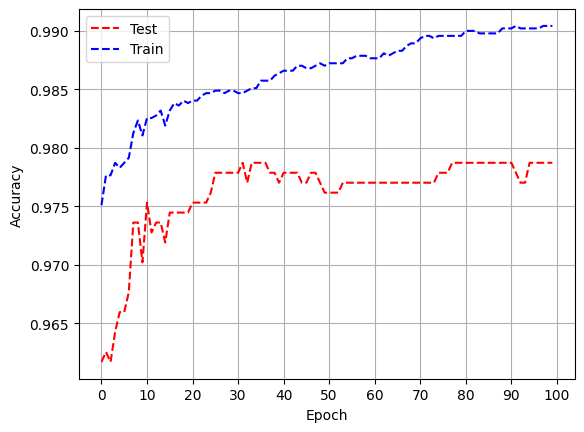

In [9]:
plt.plot(test_acc,label='Test',linestyle='--',color='r')
plt.plot(train_acc,label='Train',linestyle='--',color='b')
plt.grid()
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.xticks([i*10 for i in range(11)])
plt.legend()
plt.show()

In [10]:
#Calculating fpr and tpr to plot ROC
y_pred_proba = model.predict(dtest)
fpr, tpr, thresholds = roc_curve(y_test, y_pred_proba)
roc_auc = roc_auc_score(y_test, y_pred_proba)

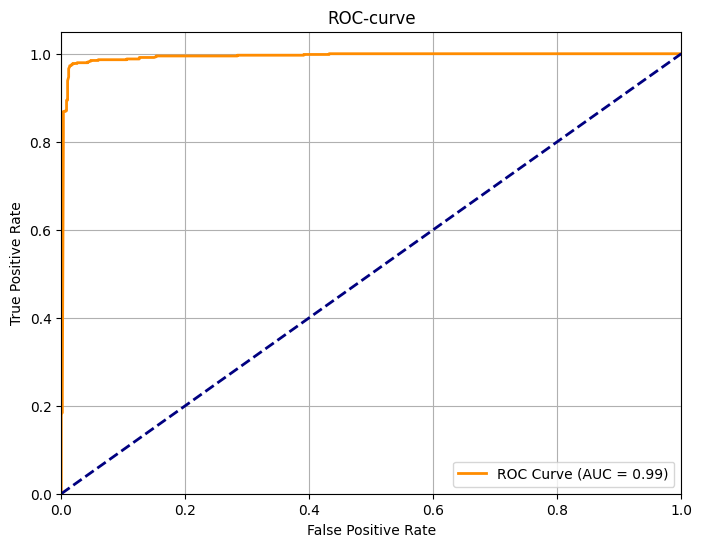

In [11]:
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='darkorange', lw=2, 
         label=f'ROC Curve (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC-curve')
plt.legend(loc="lower right")
plt.grid()
plt.show()

In [12]:
#Final test accuracy
y_pred = (y_pred_proba > 0.5).astype(int)
accuracy = accuracy_score(y_test, y_pred)
print(f"Test Accuracy: {accuracy:.4f}")

Test Accuracy: 0.9787
